In [170]:
import numpy as np
import scipy as sp
import scipy.stats
import itertools
import logging
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
import torch.nn.functional as F
from argparse import ArgumentParser
from torch.distributions import MultivariateNormal
from torch import nn

In [171]:
DEFAULT_MIN_BIN_WIDTH = 1e-3
DEFAULT_MIN_BIN_HEIGHT = 1e-3
DEFAULT_MIN_DERIVATIVE = 1e-3


In [172]:
def searchsorted(bin_locations, inputs, eps=1e-6):
    bin_locations[..., -1] += eps
    return torch.sum(
        inputs[..., None] >= bin_locations,
        dim=-1
    ) - 1


In [4]:

def RQS(inputs, unnormalized_widths, unnormalized_heights,
        unnormalized_derivatives, inverse=False, left=0., right=1.,
        bottom=0., top=1., min_bin_width=DEFAULT_MIN_BIN_WIDTH,
        min_bin_height=DEFAULT_MIN_BIN_HEIGHT,
        min_derivative=DEFAULT_MIN_DERIVATIVE):
    if torch.min(inputs) < left or torch.max(inputs) > right:
        raise ValueError("Input outside domain")

    num_bins = unnormalized_widths.shape[-1]

    if min_bin_width * num_bins > 1.0:
        raise ValueError('Minimal bin width too large for the number of bins')
    if min_bin_height * num_bins > 1.0:
        raise ValueError('Minimal bin height too large for the number of bins')

    widths = F.softmax(unnormalized_widths, dim=-1)
    widths = min_bin_width + (1 - min_bin_width * num_bins) * widths
    cumwidths = torch.cumsum(widths, dim=-1)
    cumwidths = F.pad(cumwidths, pad=(1, 0), mode='constant', value=0.0)
    cumwidths = (right - left) * cumwidths + left
    cumwidths[..., 0] = left
    cumwidths[..., -1] = right
    widths = cumwidths[..., 1:] - cumwidths[..., :-1]

    derivatives = min_derivative + F.softplus(unnormalized_derivatives)

    heights = F.softmax(unnormalized_heights, dim=-1)
    heights = min_bin_height + (1 - min_bin_height * num_bins) * heights
    cumheights = torch.cumsum(heights, dim=-1)
    cumheights = F.pad(cumheights, pad=(1, 0), mode='constant', value=0.0)
    cumheights = (top - bottom) * cumheights + bottom
    cumheights[..., 0] = bottom
    cumheights[..., -1] = top
    heights = cumheights[..., 1:] - cumheights[..., :-1]

    if inverse:
        bin_idx = searchsorted(cumheights, inputs)[..., None]
    else:
        bin_idx = searchsorted(cumwidths, inputs)[..., None]

    input_cumwidths = cumwidths.gather(-1, bin_idx)[..., 0]
    input_bin_widths = widths.gather(-1, bin_idx)[..., 0]

    input_cumheights = cumheights.gather(-1, bin_idx)[..., 0]
    delta = heights / widths
    input_delta = delta.gather(-1, bin_idx)[..., 0]

    input_derivatives = derivatives.gather(-1, bin_idx)[..., 0]
    input_derivatives_plus_one = derivatives[..., 1:].gather(-1, bin_idx)
    input_derivatives_plus_one = input_derivatives_plus_one[..., 0]

    input_heights = heights.gather(-1, bin_idx)[..., 0]

    if inverse:
        a = (((inputs - input_cumheights) * (input_derivatives \
            + input_derivatives_plus_one - 2 * input_delta) \
            + input_heights * (input_delta - input_derivatives)))
        b = (input_heights * input_derivatives - (inputs - input_cumheights) \
            * (input_derivatives + input_derivatives_plus_one \
            - 2 * input_delta))
        c = - input_delta * (inputs - input_cumheights)

        discriminant = b.pow(2) - 4 * a * c
        assert (discriminant >= 0).all()

        root = (2 * c) / (-b - torch.sqrt(discriminant))
        outputs = root * input_bin_widths + input_cumwidths

        theta_one_minus_theta = root * (1 - root)
        denominator = input_delta \
                      + ((input_derivatives + input_derivatives_plus_one \
                      - 2 * input_delta) * theta_one_minus_theta)
        derivative_numerator = input_delta.pow(2) \
                               * (input_derivatives_plus_one * root.pow(2) \
                                + 2 * input_delta * theta_one_minus_theta \
                                + input_derivatives * (1 - root).pow(2))
        logabsdet = torch.log(derivative_numerator) - 2 * torch.log(denominator)
        return outputs, -logabsdet
    else:
        theta = (inputs - input_cumwidths) / input_bin_widths
        theta_one_minus_theta = theta * (1 - theta)

        numerator = input_heights * (input_delta * theta.pow(2) \
                    + input_derivatives * theta_one_minus_theta)
        denominator = input_delta + ((input_derivatives \
                      + input_derivatives_plus_one - 2 * input_delta) \
                      * theta_one_minus_theta)
        outputs = input_cumheights + numerator / denominator

        derivative_numerator = input_delta.pow(2) \
                               * (input_derivatives_plus_one * theta.pow(2) \
                                + 2 * input_delta * theta_one_minus_theta \
                                + input_derivatives * (1 - theta).pow(2))
        logabsdet = torch.log(derivative_numerator) - 2 * torch.log(denominator)
        return outputs, logabsdet

In [5]:
import torch.nn.init as init
DEFAULT_MIN_BIN_WIDTH = 1e-3
DEFAULT_MIN_BIN_HEIGHT = 1e-3
DEFAULT_MIN_DERIVATIVE = 1e-3




def unconstrained_RQS(inputs, unnormalized_widths, unnormalized_heights,
                      unnormalized_derivatives, inverse=False,
                      tail_bound=1., min_bin_width=DEFAULT_MIN_BIN_WIDTH,
                      min_bin_height=DEFAULT_MIN_BIN_HEIGHT,
                      min_derivative=DEFAULT_MIN_DERIVATIVE):
    inside_intvl_mask = (inputs >= -tail_bound) & (inputs <= tail_bound)
    outside_interval_mask = ~inside_intvl_mask

    outputs = torch.zeros_like(inputs)
    logabsdet = torch.zeros_like(inputs)

    unnormalized_derivatives = F.pad(unnormalized_derivatives, pad=(1, 1))
    constant = np.log(np.exp(1 - min_derivative) - 1)
    unnormalized_derivatives[..., 0] = constant
    unnormalized_derivatives[..., -1] = constant

    outputs[outside_interval_mask] = inputs[outside_interval_mask]
    logabsdet[outside_interval_mask] = 0

    outputs[inside_intvl_mask], logabsdet[inside_intvl_mask] = RQS(
        inputs=inputs[inside_intvl_mask],
        unnormalized_widths=unnormalized_widths[inside_intvl_mask, :],
        unnormalized_heights=unnormalized_heights[inside_intvl_mask, :],
        unnormalized_derivatives=unnormalized_derivatives[inside_intvl_mask, :],
        inverse=inverse,
        left=-tail_bound, right=tail_bound, bottom=-tail_bound, top=tail_bound,
        min_bin_width=min_bin_width,
        min_bin_height=min_bin_height,
        min_derivative=min_derivative
    )
    return outputs, logabsdet

class FCNN(nn.Module):
    """
    Simple fully connected neural network.
    """
    def __init__(self, in_dim, out_dim, hidden_dim):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, out_dim),
        )

    def forward(self, x):
        return self.network(x)


class NSF_AR(nn.Module):


    """
    Neural spline flow, auto-regressive.
    [Durkan et al. 2019]
    """
    def __init__(self, dim, K = 5, B = 3, hidden_dim = 8, base_network = FCNN):
        super().__init__()
        self.dim = dim
        self.K = K
        self.B = B
        self.layers = nn.ModuleList()
        self.init_param = nn.Parameter(torch.Tensor(3 * K - 1))
        for i in range(1, dim):
            self.layers += [base_network(i, 3 * K - 1, hidden_dim)]
        self.reset_parameters()

    def reset_parameters(self):
        init.uniform_(self.init_param, - 1 / 2, 1 / 2)

    def forward(self, x):
        z = torch.zeros_like(x)
        log_det = torch.zeros(z.shape[0])
        for i in range(self.dim):
            if i == 0:
                init_param = self.init_param.expand(x.shape[0], 3 * self.K - 1)
                W, H, D = torch.split(init_param, self.K, dim = 1)
            else:
                out = self.layers[i - 1](x[:, :i])
                W, H, D = torch.split(out, self.K, dim = 1)
            W, H = torch.softmax(W, dim = 1), torch.softmax(H, dim = 1)
            W, H = 2 * self.B * W, 2 * self.B * H
            D = F.softplus(D)
            z[:, i], ld = unconstrained_RQS(
                x[:, i], W, H, D, inverse=False, tail_bound=self.B)
            log_det += ld
        return z, log_det

    def inverse(self, z):
        x = torch.zeros_like(z)
        log_det = torch.zeros(x.shape[0])
        for i in range(self.dim):
            if i == 0:
                init_param = self.init_param.expand(x.shape[0], 3 * self.K - 1)
                W, H, D = torch.split(init_param, self.K, dim = 1)
            else:
                out = self.layers[i - 1](x[:, :i])
                W, H, D = torch.split(out, self.K, dim = 1)
            W, H = torch.softmax(W, dim = 1), torch.softmax(H, dim = 1)
            W, H = 2 * self.B * W, 2 * self.B * H
            D = F.softplus(D)
            x[:, i], ld = unconstrained_RQS(
                z[:, i], W, H, D, inverse = True, tail_bound = self.B)
            log_det += ld
        return x, log_det

    
    
import math
class MAF(nn.Module):
    """
    Masked auto-regressive flow.
    [Papamakarios et al. 2018]
    """
    def __init__(self, dim, hidden_dim = 8, base_network=FCNN):
        super().__init__()
        self.dim = dim
        self.layers = nn.ModuleList()
        self.initial_param = nn.Parameter(torch.Tensor(2))
        for i in range(1, dim):
            self.layers += [base_network(i, 2, hidden_dim)]
        self.reset_parameters()

    def reset_parameters(self):
        init.uniform_(self.initial_param, -math.sqrt(0.5), math.sqrt(0.5))

    def forward(self, x):
        z = torch.zeros_like(x)
        log_det = torch.zeros(z.shape[0])
        for i in range(self.dim):
            if i == 0:
                mu, alpha = self.initial_param[0], self.initial_param[1]
            else:
                out = self.layers[i - 1](x[:, :i])
                mu, alpha = out[:, 0], out[:, 1]
            z[:, i] = (x[:, i] - mu) / torch.exp(alpha)
            log_det -= alpha
        return z.flip(dims=(1,)), log_det

    def inverse(self, z):
        x = torch.zeros_like(z)
        log_det = torch.zeros(z.shape[0])
        z = z.flip(dims=(1,))
        for i in range(self.dim):
            if i == 0:
                mu, alpha = self.initial_param[0], self.initial_param[1]
            else:
                out = self.layers[i - 1](x[:, :i])
                mu, alpha = out[:, 0], out[:, 1]
            x[:, i] = mu + torch.exp(alpha) * z[:, i]
            log_det += alpha
        return x, log_det

functional_derivatives = {
    torch.tanh: lambda x: 1 - torch.pow(torch.tanh(x), 2),
    F.leaky_relu: lambda x: (x > 0).type(torch.FloatTensor) + \
                            (x < 0).type(torch.FloatTensor) * -0.01,
    F.elu: lambda x: (x > 0).type(torch.FloatTensor) + \
                     (x < 0).type(torch.FloatTensor) * torch.exp(x)
}

 
class Planar(nn.Module):
    """
    Planar flow.
        z = f(x) = x + u h(wᵀx + b)
    [Rezende and Mohamed, 2015]
    """
    def __init__(self, dim, nonlinearity=torch.tanh):
        super().__init__()
        self.h = nonlinearity
        self.w = nn.Parameter(torch.Tensor(dim))
        self.u = nn.Parameter(torch.Tensor(dim))
        self.b = nn.Parameter(torch.Tensor(1))
        self.reset_parameters(dim)

    def reset_parameters(self, dim):
        init.uniform_(self.w, -math.sqrt(1/dim), math.sqrt(1/dim))
        init.uniform_(self.u, -math.sqrt(1/dim), math.sqrt(1/dim))
        init.uniform_(self.b, -math.sqrt(1/dim), math.sqrt(1/dim))

    def forward(self, x):
        """
        Given x, returns z and the log-determinant log|df/dx|.
        Returns
        -------
        """
        if self.h in (F.elu, F.leaky_relu):
            u = self.u
        elif self.h == torch.tanh:
            scal = torch.log(1+torch.exp(self.w @ self.u)) - self.w @ self.u - 1
            u = self.u + scal * self.w / torch.norm(self.w) ** 2
        else:
            raise NotImplementedError("Non-linearity is not supported.")
        lin = torch.unsqueeze(x @ self.w, 1) + self.b
        z = x + u * self.h(lin)
        phi = functional_derivatives[self.h](lin) * self.w
        log_det = torch.log(torch.abs(1 + phi @ u) + 1e-4)
        return z, log_det

    def inverse(self, z):
        raise NotImplementedError("Planar flow has no algebraic inverse.")


class Radial(nn.Module):
    """
    Radial flow.
        z = f(x) = = x + β h(α, r)(z − z0)
    [Rezende and Mohamed 2015]
    """
    def __init__(self, dim):
        super().__init__()
        self.x0 = nn.Parameter(torch.Tensor(dim))
        self.log_alpha = nn.Parameter(torch.Tensor(1))
        self.beta = nn.Parameter(torch.Tensor(1))

    def reset_parameters(dim):
        init.uniform_(self.z0, -math.sqrt(1/dim), math.sqrt(1/dim))
        init.uniform_(self.log_alpha, -math.sqrt(1/dim), math.sqrt(1/dim))
        init.uniform_(self.beta, -math.sqrt(1/dim), math.sqrt(1/dim))

    def forward(self, x):
        """
        Given x, returns z and the log-determinant log|df/dx|.
        """
        m, n = x.shape
        r = torch.norm(x - self.x0)
        h = 1 / (torch.exp(self.log_alpha) + r)
        beta = -torch.exp(self.log_alpha) + torch.log(1 + torch.exp(self.beta))
        z = x + beta * h * (x - self.x0)
        log_det = (n - 1) * torch.log(1 + beta * h) + \
                  torch.log(1 + beta * h - \
                            beta * r / (torch.exp(self.log_alpha) + r) ** 2)
        return z, log_det


    
class NormalizingFlowModel(nn.Module):

    def __init__(self, prior, flows):
        super().__init__()
        self.prior = prior
        self.flows = nn.ModuleList(flows)

    def forward(self, x):
        m, _ = x.shape
        log_det = torch.zeros(m)
        for flow in self.flows:
            x, ld = flow.forward(x)
            log_det += ld
        z, prior_logprob = x, self.prior.log_prob(x)
        return z, prior_logprob, log_det

    def inverse(self, z):
        m, _ = z.shape
        log_det = torch.zeros(m)
        for flow in self.flows[::-1]:
            z, ld = flow.inverse(z)
            log_det += ld
        x = z
        return x, log_det

    def sample(self, n_samples):
        z = self.prior.sample((n_samples,))
        x, _ = self.inverse(z)
        return x

def gen_data(n=512):
    return np.r_[np.random.randn(n // 2, 1) + np.array([2]),
                 np.random.randn(n // 2, 1) + np.array([-2])]

def plot_data(x, bandwidth = 0.2, **kwargs):
    kde = sp.stats.gaussian_kde(x[:,0])
    x_axis = np.linspace(-5, 5, 200)
    plt.plot(x_axis, kde(x_axis), **kwargs)



In [166]:
sum(p.numel() for p in model.parameters())

12

In [178]:
import seaborn as sns

<AxesSubplot:ylabel='Density'>

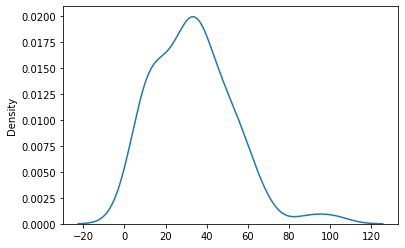

In [179]:
sns.kdeplot(x.squeeze())

In [176]:
import numpy as np
import scipy as sp
import scipy.stats
import itertools
import logging
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
import torch.nn.functional as F
from argparse import ArgumentParser
from torch.distributions import MultivariateNormal



def gen_data(n=72):
#     return np.r_[np.random.randn(n // 2, 1) + np.array([2]),
#                  np.random.randn(n // 2, 1) + np.array([-2])]

    data = np.load('../datasets/Combined_GWTC_m1m2chieffz.npz')

    m1 = data['m1'][:, :1]
    return m1

def plot_data(x, bandwidth = 0.2, **kwargs):
    kde = sp.stats.gaussian_kde(x[:,0])
    x_axis = np.linspace(-5, 5, 200)
    plt.plot(x_axis, kde(x_axis), **kwargs)


if __name__ == "__main__":

    argparser = ArgumentParser()
    argparser.add_argument("--n", default=72, type=int)
    argparser.add_argument("--flows", default=4, type=int)
    argparser.add_argument("--flow", default="Planar", type=str)
    argparser.add_argument("--iterations", default=8192, type=int)
    args = argparser.parse_args([])

    logging.basicConfig(level=logging.DEBUG)
    logger = logging.getLogger(__name__)

    flow = eval(args.flow)
    flows = [flow(dim=1) for _ in range(args.flows)]
    prior = MultivariateNormal(torch.zeros(1), torch.eye(1))
    model = NormalizingFlowModel(prior, flows)

    optimizer = optim.Adam(model.parameters(), lr=0.005)
    x = torch.Tensor(gen_data(args.n))
    
    raise

    plot_data(x, color = "black")
    plt.show()

    for i in range(x.shape[1]):
        x[:,i] = (x[:,i] - torch.mean(x[:,i])) / torch.std(x[:,i])

    for i in range(args.iterations):
        optimizer.zero_grad()
        z, prior_logprob, log_det = model(x)
        logprob = prior_logprob + log_det
        loss = -torch.mean(prior_logprob + log_det)
        loss.backward()
        optimizer.step()
        if i % 100 == 0:
            logger.info(f"Iter: {i}\t" +
                        f"Logprob: {logprob.mean().data:.2f}\t" +
                        f"Prior: {prior_logprob.mean().data:.2f}\t" +
                        f"LogDet: {log_det.mean().data:.2f}")

    with torch.no_grad():
        plt.figure(figsize=(8, 3))
        plt.subplot(1, 3, 1)
        plot_data(x, color="black", alpha=0.5)
        plt.title("Training data")
        plt.subplot(1, 3, 2)
        plot_data(z.data, color="darkblue", alpha=0.5)
        plt.title("Latent space")
        plt.subplot(1, 3, 3)
        x = torch.linspace(-5, 5, 512)[:, None]
        z, prior_logprob, log_det = model(x)
        p = torch.exp(prior_logprob + log_det)
        plt.plot(x.squeeze(), p.squeeze())
        plt.show()

RuntimeError: No active exception to reraise

In [150]:
x = torch.linspace(-3, 5, 512)[:, None]
z, prior_logprob, log_det = model(x)



In [151]:
d = gen_data()

In [152]:
mean = d.mean()
std = d.std()

In [153]:
x = x * std + mean

In [154]:
# x = x.exp()

In [155]:
x.max()

tensor(128.3926)

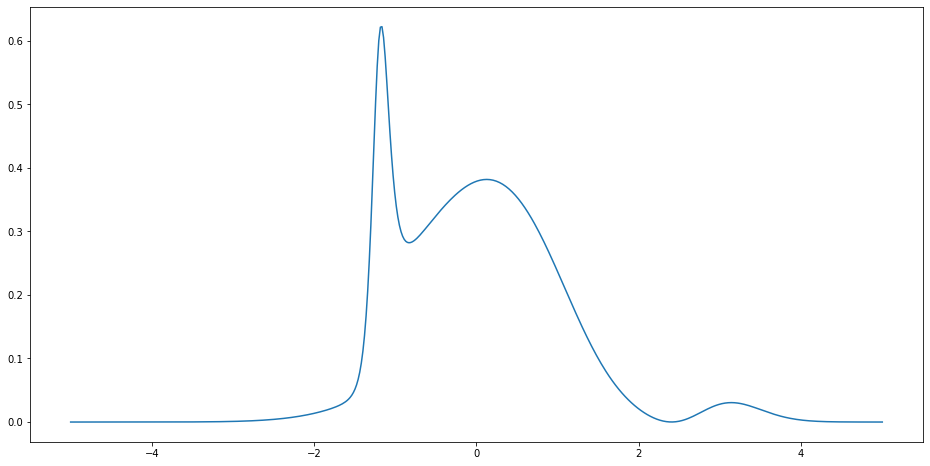

In [169]:
with torch.no_grad():
    plt.figure(figsize=(16, 8))
    plt.plot(x.squeeze(), torch.exp(prior_logprob + log_det).squeeze())

$$$p_\theta(x):= \frac{e^{-f_\theta(x)} q_\theta(x)}{\int \, dx\,  e^{-f_\theta(x)} q_\theta(x)} = \frac{e^{-f_\theta(x)} q_\theta(x)}{\mathbb{E}_q[f_\theta(x)}] $$

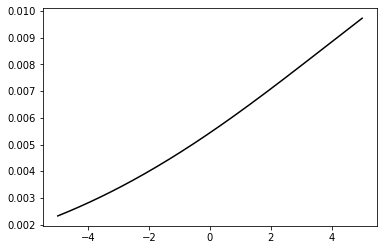

ValueError: Expected value argument (Tensor of shape (79, 1)) to be within the support (IndependentConstraint(Real(), 1)) of the distribution MultivariateNormal(loc: tensor([0.]), covariance_matrix: tensor([[1.]])), but found invalid values:
tensor([[nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan]], grad_fn=<AddBackward0>)

In [163]:
import numpy as np
import scipy as sp
import scipy.stats
import itertools
import logging
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
import torch.nn.functional as F
from argparse import ArgumentParser
from torch.distributions import MultivariateNormal



def gen_data(n=72):
#     return np.r_[np.random.randn(n // 2, 1) + np.array([2]),
#                  np.random.randn(n // 2, 1) + np.array([-2])]

    data = np.load('../datasets/Combined_GWTC_m1m2chieffz.npz')

    m1 = data['m1'][:, :1]
    return m1

def plot_data(x, bandwidth = 0.2, **kwargs):
    kde = sp.stats.gaussian_kde(x[:,0])
    x_axis = np.linspace(-5, 5, 200)
    plt.plot(x_axis, kde(x_axis), **kwargs)


if __name__ == "__main__":

    argparser = ArgumentParser()
    argparser.add_argument("--n", default=72, type=int)
    argparser.add_argument("--flows", default=6, type=int)
    argparser.add_argument("--flow", default="Radial", type=str)
    argparser.add_argument("--iterations", default=8192, type=int)
    args = argparser.parse_args([])

    logging.basicConfig(level=logging.DEBUG)
    logger = logging.getLogger(__name__)

    flow = eval(args.flow)
    flows = [flow(dim=1) for _ in range(args.flows)]
    prior = MultivariateNormal(torch.zeros(1), torch.eye(1))
    model = NormalizingFlowModel(prior, flows)

    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    x = torch.Tensor(gen_data(args.n))

    plot_data(x, color = "black")
    plt.show()

    for i in range(x.shape[1]):
        x[:,i] = (x[:,i] - torch.mean(x[:,i])) / torch.std(x[:,i])

    for i in range(args.iterations):
        optimizer.zero_grad()
        z, prior_logprob, log_det = model(x)
        logprob = prior_logprob + log_det
        loss = -torch.mean(prior_logprob + log_det)
        loss.backward()
        optimizer.step()
        if i % 100 == 0:
            logger.info(f"Iter: {i}\t" +
                        f"Logprob: {logprob.mean().data:.2f}\t" +
                        f"Prior: {prior_logprob.mean().data:.2f}\t" +
                        f"LogDet: {log_det.mean().data:.2f}")

    with torch.no_grad():
        plt.figure(figsize=(8, 3))
        plt.subplot(1, 3, 1)
        plot_data(x, color="black", alpha=0.5)
        plt.title("Training data")
        plt.subplot(1, 3, 2)
        plot_data(z.data, color="darkblue", alpha=0.5)
        plt.title("Latent space")
        plt.subplot(1, 3, 3)
        x = torch.linspace(-5, 5, 512)[:, None]
        z, prior_logprob, log_det = model(x)
        p = torch.exp(prior_logprob + log_det)
        plt.plot(x.squeeze(), p.squeeze())
        plt.show()